In [54]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import math
import random

## Task 1 -- Image Validator

##### Size Validation

In [6]:
def image_size_validator(img):
    width, height = img.shape[:2]
    if width != 512 and height != 512:
        print("Image size is not 512x512")
        return False
    return True

##### BackGround Color Validaton

In [7]:
def background_color_validator(img):
    width, height = img.shape[:2]
    x_center = width // 2
    y_center = height // 2
    radius = width//2

    # compute euclidean distance
    def compute_distance(x, y):
        return math.sqrt((x_center - x) ** 2 + (y_center - y) ** 2)

    # check for transparency
    for x in range(width):
        for y in range(height):
            distance = compute_distance(x, y)
            pixel = img[y, x]
            if (distance > radius+1.5):
                if (pixel[3] != 0):
                    print("there are colored pixels outside the circle")
                    return False

    return True


##### Happy Colors Helper Functions 


In [8]:
def find_avg_color(image):

    if (image.shape[-1] != 4):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)

    width, height = image.shape[:2]

    
    r_total = 0
    g_total = 0
    b_total = 0
    count = 0

    for i in range(width):
        for j in range(height):
            if (image[i][j][3] != 0):
                r, g, b, a = image[i][j]
                r_total += r
                g_total += g
                b_total += b
                count += 1

    r_avg = r_total/count
    g_avg = g_total/count
    b_avg = b_total/count

    return (r_avg, g_avg, b_avg)


In [9]:

def calculate_color_similarity(color1, color2):
    # Calculate the Euclidean distance between two RGB colors
    return np.linalg.norm(np.array(color1) - np.array(color2))


def evaluate_happiness_of_avg_color(avg_color):
    happy_colors_mapping = {
        (0, 255, 0): "Green",
        (0, 0, 255): "Blue",
        (255, 255, 0): "Yellow",
        (0, 255, 255): "Cyan",
        (255, 0, 255): "Magenta",
    }

    similarity_scores = []
    min_similarity_score = 0
    # Loop over each happy color in the mapping
    for happy_color in happy_colors_mapping.keys():

        # Calculate the similarity score between the avg color and the current happy color
        similarity_score = calculate_color_similarity(avg_color, happy_color)

        # Add the similarity score to the list
        similarity_scores.append(similarity_score)

    # Find the minimum similarity score from the list that indicates which happy color it is most similar to
    min_similarity_score = min(similarity_scores)

    threshold = 185

    if (min_similarity_score < threshold):
        return True

    print("Colors don't give a happy feeling")
    return False


##### Happy Color Validator

In [10]:

def happy_colors_validator(img):

    avg_color = find_avg_color(img)

    return evaluate_happiness_of_avg_color(avg_color)


### Image Validator

In [11]:
def image_validator(img):

    if image_size_validator(img) and background_color_validator(img) and happy_colors_validator(img):
        print("Image is valid")
        return True

    print("Image is invalid")
    return False


### Testing

In [67]:
file_path = 'c6.png'

image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

print(image_validator(image))


there are colored pixels outside the circle
Image is invalid
False


# Task 2 -- Image formatter


##### Image Resizer

In [13]:
def reshape_image(img):

    if (image_size_validator(img)):
        return img

    width, height = img.shape[:2]

    scale = 512.0 / max(width, height)

    new_img = cv2.resize(img, (512, 512), fx=scale,
                         fy=scale, interpolation=cv2.INTER_CUBIC)

    return new_img


##### Bacgkround Color Helper Function

In [94]:
def get_circle_prams(image):

    # Converting the image to grayscale
    if image.shape[-1] == 4:  # Checking if the image has an alpha channel
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
    else:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Applying Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 0)

    # Detecting circles using Hough Circle Transform
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=30, minRadius=0, maxRadius=500)

    if circles is None:
        raise ValueError("No circles detected.")

    # Assuming only one circle is detected
    circle = np.uint16(np.around(circles[0][0]))

    # Extracting circle center coordinates and radius
    center_x, center_y = circle[0], circle[1]
    radius = circle[2]

    return center_x, center_y, radius


##### Background Color Remover

In [15]:
def remove_background_color(image):
    if (background_color_validator(image)):
        return image

    center_x, center_y, radius = get_circle_prams(image)

    # Creating a mask to keep only the pixels inside the circle
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    cv2.circle(mask, (center_x, center_y), radius, 255, -1)

    # Extracting the region inside the circle   
    roi = cv2.bitwise_and(image, image, mask=mask)

    return roi


In [19]:
def colored_pixels_size(image):
    return np.sum(image[:,:,3]!=0)

##### Happy Colors Schema

In [22]:
shades_of_blue = np.array([
    [0, 0, 255],  # Royal Blue
    [0, 0, 128],  # Navy Blue
    [0, 0, 205],  # Medium Blue
    [135, 206, 235],  # Sky Blue
    [70, 130, 180],   # Steel Blue
    [0, 191, 255],    # Deep Sky Blue
    [30, 144, 255],   # Dodger Blue
    [0, 128, 128],    # Teal
    [0, 0, 139],      # Dark Blue
    [25, 25, 112],    # Midnight Blue
    [0, 102, 204],    # Cerulean Blue
    [0, 119, 190],    # Sapphire
    [0, 68, 204],     # Persian Blue
    [173, 216, 230],  # Light Blue
    [32, 178, 170],   # Light Sea Green
    [70, 130, 180]    # Steel Blue
])

shades_of_green = np.array([
    [0, 128, 0],      # Green
    [0, 255, 0],      # Lime Green
    [0, 100, 0],      # Dark Green
    [34, 139, 34],    # Forest Green
    [50, 205, 50],    # Lime
    [0, 128, 128],    # Teal
    [46, 139, 87],    # Sea Green
    [60, 179, 113],   # Medium Sea Green
    [0, 255, 127],    # Spring Green
    [0, 250, 154],    # Medium Spring Green
    [154, 205, 50],   # Yellow Green
    [144, 238, 144],  # Light Green
    [0, 128, 0],      # Green
    [0, 255, 0],      # Lime Green
    [0, 100, 0],      # Dark Green
    [107, 142, 35],   # Olive Drab
])

shades_of_orange = np.array([
    [255, 165, 0],    # Orange
    [255, 140, 0],    # Dark Orange
    [255, 69, 0],     # Red Orange
    [255, 127, 80],   # Coral
    [255, 99, 71],    # Tomato
    [255, 228, 181],  # Moccasin
    [255, 215, 0],    # Gold
    [255, 250, 205],  # Lemon Chiffon
    [255, 193, 37],   # Flax
    [255, 140, 0],    # Dark Orange
    [218, 165, 32],   # Goldenrod
    [255, 165, 0],    # Orange
    [255, 69, 0],     # Red Orange
    [255, 215, 0],    # Gold
    [255, 140, 0],    # Dark Orange
    [205, 133, 63],   # Peru
])

##### Happy Colors Adaptor

In [90]:
def adjust_happiness(image):

    if (happy_colors_validator(image)):
        return image

    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    
    width, height = image.shape[:2]

    colored_pixels_count = colored_pixels_size(image)
    block_size = colored_pixels_count//3

    random_happy_color = None
    pick = 1
    count = 0
    picked = False

    shades_map = {
        1: shades_of_blue,
        2: shades_of_orange,
        3: shades_of_green,
    }

    for x in range(width):
        for y in range(height):
            pixel = image[y, x]
            if (pixel[3] > 0):
                if (count < block_size and not picked):
                    random_happy_color = random.choice(shades_map[pick])
                    picked = True

                elif (count == block_size):
                    count = 0
                    pick += 1
                    picked = False

                count += 1
                image[y, x, :3] = random_happy_color

    return image


### Image Formatter

In [77]:
def image_formatter(image):
    image = reshape_image(image)
    image = remove_background_color(image)
    image = adjust_happiness(image)

    return image


### Testing

##### keep runing until you get your desired combination of colors :)

Colors don't give a happy feeling


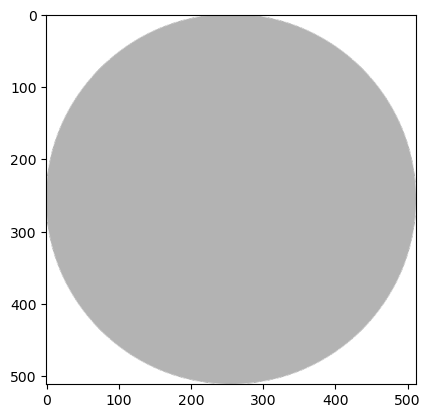

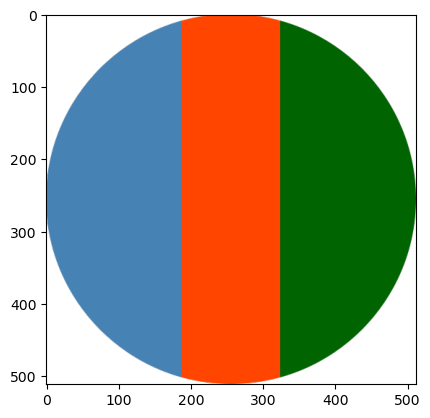

In [93]:
file_p = 'c12.png'

img = cv2.imread(file_p, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
new_img = image_formatter(img)

plt.imshow(img)
plt.show()

plt.imshow(new_img)
plt.show()
